In [1]:
%matplotlib inline

# Variance Partitioning

In [2]:
import numpy as np

from himalaya.backend import set_backend
from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from himalaya.kernel_ridge import ColumnKernelizer
from himalaya.utils import generate_multikernel_dataset

from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

In this example, we use the ``cupy`` backend (GPU).



In [30]:
backend = set_backend("torch", on_error="warn")

In [31]:
n_kernels = 2
n_targets = 50
n_samples_train = 600
n_samples_test = 300

## Generate a random dataset
- X_train : array of shape (n_samples_train, n_features)
- X_test : array of shape (n_samples_test, n_features)
- Y_train : array of shape (n_samples_train, n_targets)
- Y_test : array of shape (n_samples_test, n_targets)

In [36]:
(X_train, X_test, Y_train, Y_test, kernel_weights, n_features_list) = generate_multikernel_dataset(n_kernels=n_kernels, n_targets=n_targets,
                                                                                                     n_samples_train=n_samples_train,
                                                                                                     n_samples_test=n_samples_test,
                                                                                                     random_state=42)
# projection on the simplex, making kernel weights sum to one.
kernel_weights = backend.to_numpy(kernel_weights)
kernel_weights[kernel_weights < 0] = 0.
kernel_weights /= np.sum(kernel_weights, 1)[:, None]

feature_names = [f"Feature space {ii}" for ii in range(len(n_features_list))]

# Variance Partitioning

## Prepare kernelizers

In [14]:
# Find the start and end of each feature space X in Xs
start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
slices = [
    slice(start, end)
    for start, end in zip(start_and_end[:-1], start_and_end[1:])
]

# Create a different ``Kernelizer`` for each feature space.
kernelizers = [("space %d" % ii, Kernelizer(), slice_)
               for ii, slice_ in enumerate(slices)]
column_kernelizer = ColumnKernelizer(kernelizers)

## Single models

In [ ]:
solver_params = dict(n_iter=5, alphas=np.logspace(-10, 10, 41))

single_pipelines = []
for kernelizer in kernelizers:
    single_model = KernelRidgeCV(kernels="precomputed", solver="random_search",
                        solver_params=solver_params, random_state=42)
    pipe_1 = make_pipeline(column_kernelizer, model_1)

    # Fit the model on all targets
    pipe_1.fit(X_train, Y_train)

## Joint model

### Define the random-search model
We use very few iteration on purpose, to make the random search suboptimal,
and refine it with hyperparameter gradient descent.



In [15]:
solver_params = dict(n_iter=5, alphas=np.logspace(-10, 10, 41))

model_1 = MultipleKernelRidgeCV(kernels="precomputed", solver="random_search",
                                solver_params=solver_params, random_state=42)
pipe_1 = make_pipeline(column_kernelizer, model_1)

# Fit the model on all targets
pipe_1.fit(X_train, Y_train)

[........................................] 100% | 8.06 sec | 5 random sampling with cv | 


Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed', random_state=42,
                                       solver_params={'alphas': array([1.00000000e-10, 3.16227766e-10, 1.000...
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06, 3.16227766e+06, 1.00000000e+07, 3.16227766e+07,
       1.00000000e+08, 3.16227766e+08, 1.00000000e+09, 3.16227766e+09,
       1.00000000e+10]),
                                                      'n_iter': 5}))])

### Define the gradient-descent model

In [16]:
solver_params = dict(max_iter=10, hyper_gradient_method="direct",
                     max_iter_inner_hyper=10,
                     initial_deltas="here_will_go_the_previous_deltas")

model_2 = MultipleKernelRidgeCV(kernels="precomputed", solver="hyper_gradient",
                                solver_params=solver_params)
pipe_2 = make_pipeline(column_kernelizer, model_2)

### Use the random-search to initialize the gradient-descent

In [17]:
# We might want to refine only the best predicting targets, since the
# hyperparameter gradient descent is less efficient over many targets.
top = 100  # top 60%
best_cv_scores = backend.to_numpy(pipe_1[-1].cv_scores_.max(0))
mask = best_cv_scores > np.percentile(best_cv_scores, 100 - top)

pipe_2[-1].solver_params['initial_deltas'] = pipe_1[-1].deltas_[:, mask]
pipe_2.fit(X_train, Y_train[:, mask])

[........................................] 100% | 7.11 sec | hypergradient_direct | 


Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(transformers=[('space 0', Kernelizer(),
                                                 slice(np.int64(0), np.int64(1000), None)),
                                                ('space 1', Kernelizer(),
                                                 slice(np.int64(1000), np.int64(2000), None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver='hyper_gradient',
                                       solver_params={'hyper_gradient_method': 'direct',
                                                      'initial_d...
        -10.716631 ,  -4.142245 , -10.716631 ,   9.673265 , -13.334848 ,
          5.0680957,   9.374699 ,  22.337484 ,   8.223406 ,  22.337484 ,
         22.337484 ,  22.337484 ,  -6.743397 ,  -6.743397 , -37.196358 ,
        -37.196358 , -12.183556 ,  -2.990952 ,  -4.142245 ,  -4.142245 ,
         -4.142245 ,  -4.142245 , -12.183556 , -13.334848 ,  10.824558 ,
         -5.592105 ,  22.337484 , -14.48614  ,  -5.293537 ]],
      dtype=float32),
                                                      'max_iter': 10,
                                                      'max_iter_inner_hyper': 10}))])

### Compute predictions on a test set

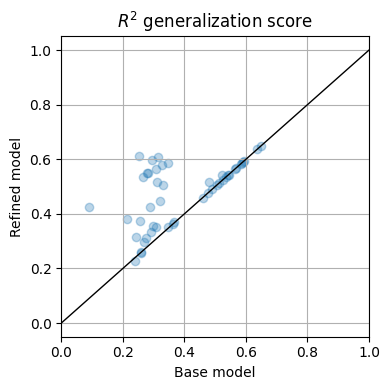

In [18]:
import matplotlib.pyplot as plt

# use the first model for all targets
test_scores_1 = pipe_1.score(X_test, Y_test)

# use the second model for the refined targets
test_scores_2 = backend.copy(test_scores_1)
test_scores_2[mask] = pipe_2.score(X_test, Y_test[:, mask])

test_scores_1 = backend.to_numpy(test_scores_1)
test_scores_2 = backend.to_numpy(test_scores_2)
plt.figure(figsize=(4, 4))
plt.scatter(test_scores_1, test_scores_2, alpha=0.3)
plt.xlim(0, 1)
plt.plot(plt.xlim(), plt.xlim(), color='k', lw=1)
plt.xlabel(r"Base model")
plt.ylabel(r"Refined model")
plt.title("$R^2$ generalization score")
plt.grid()
plt.tight_layout()
plt.show()